# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_wrangling.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,ItemTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


## Data Visualization

In [3]:
# remove transactions with price equals to 0
df = df[df['Price'] != 0]

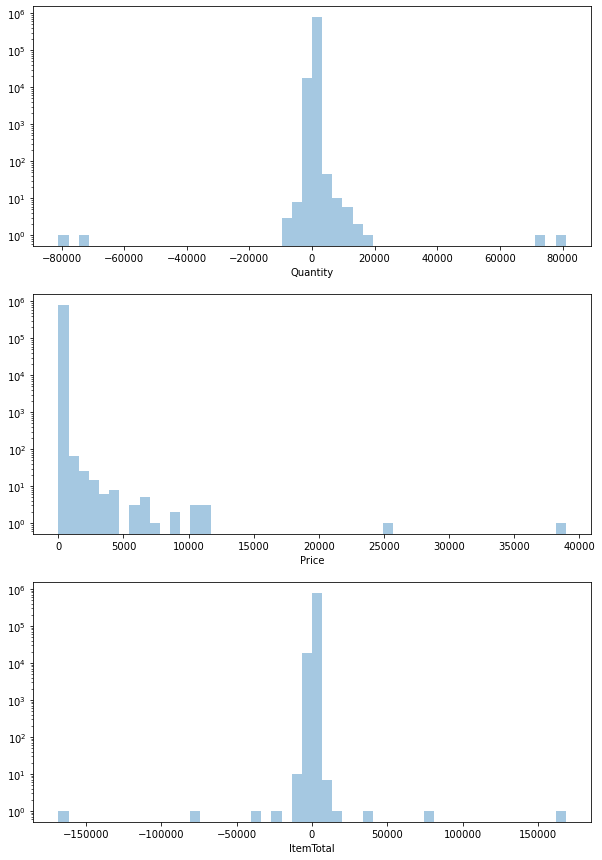

In [4]:
# histograms for quantity, price, and item total columns
fig, axs = plt.subplots(3,1,figsize=(10,15))

sns.distplot(df.Quantity,kde=False,ax=axs[0])
axs[0].set_yscale('log')

sns.distplot(df.Price,kde=False,ax=axs[1])
axs[1].set_yscale('log')

sns.distplot(df.ItemTotal,kde=False,ax=axs[2])
axs[2].set_yscale('log')

plt.show()

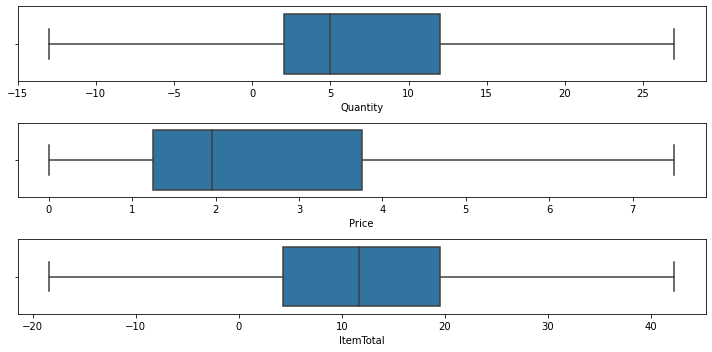

In [5]:
# box plots for quantity, price, and item total columns, without outliers
fig, axes = plt.subplots(3,1,figsize=(10,5))

sns.boxplot(x='Quantity', data=df, ax=axes[0], showfliers=False)
sns.boxplot(x='Price', data=df, ax=axes[1], showfliers=False)
sns.boxplot(x='ItemTotal', data=df, ax=axes[2], showfliers=False)

plt.tight_layout()
plt.show()

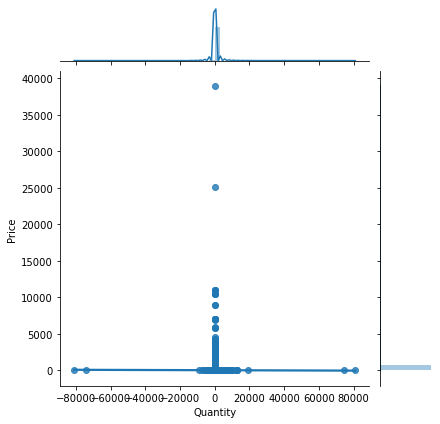

In [6]:
#create a jointplot
sns.jointplot(x='Quantity', y='Price', data=df, kind='reg')

In [7]:
# select numeric columns as a dataframe
nume_cols = df[['Quantity','Price','ItemTotal']]

Text(0.5, 1.0, 'Feature Correlation Heatmap')

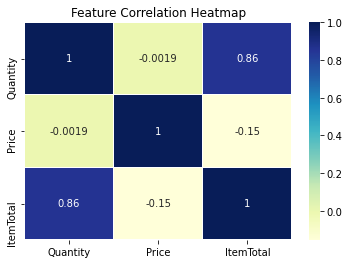

In [8]:
#create a feature correlation matrix heatmap
correlation = nume_cols.corr()
sns.heatmap(correlation, annot=True, linewidth=0.1, cmap='YlGnBu')
plt.title('Feature Correlation Heatmap')

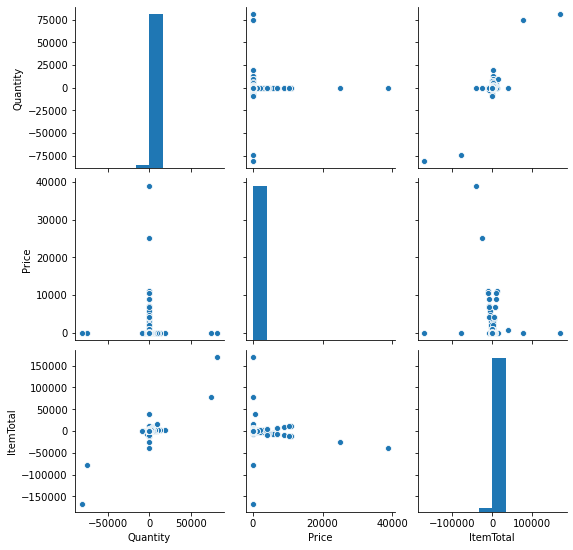

In [9]:
#create a pairplot
sns.pairplot(nume_cols)

In [10]:
# calculate order total for each order
orders = pd.DataFrame(df.groupby(['Invoice','Country','CustomerID']).ItemTotal.sum().reset_index())
orders.rename({'ItemTotal':'OrderTotal'},axis=1,inplace=True)
orders.head()

# remove orders with negative order values
# orders = orders[orders['OrderTotal'] >= 0]

,Invoice,Country,CustomerID,OrderTotal
0,489434,United Kingdom,13085,505.30
1,489435,United Kingdom,13085,145.80
2,489436,United Kingdom,13078,630.33
3,489437,United Kingdom,15362,310.75
4,489438,United Kingdom,18102,2286.24


Text(0, 0.5, 'Count')

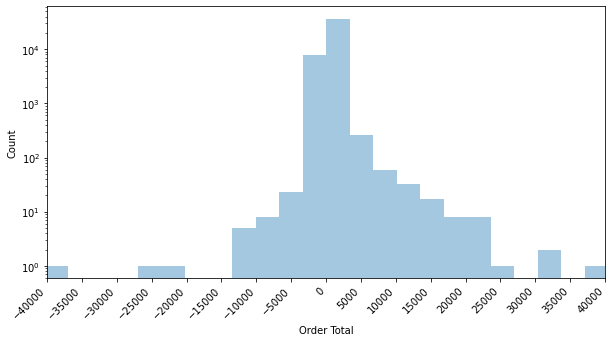

In [11]:
# histogram for order total
plt.figure(figsize=(10,5))
sns.distplot(orders.OrderTotal,kde=False,bins=100)
plt.yscale('log')
plt.xlim(-40000,40000)
plt.xticks(np.arange(-40000,40001,5000),rotation=45,ha='right')
plt.xlabel('Order Total')
plt.ylabel('Count')

Text(0.5, 0, 'Number of Orders for ')

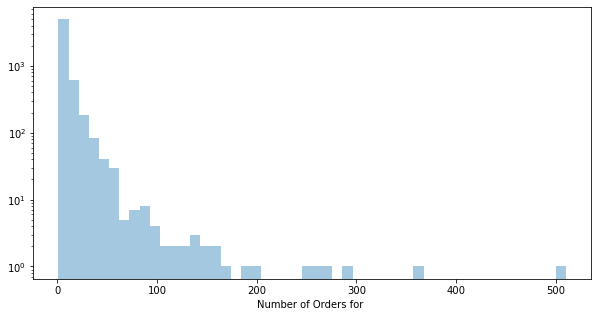

In [12]:
# calculate number of orders for each customer
order_count = orders.groupby('CustomerID').Invoice.nunique()

# histogram for order count
plt.figure(figsize=(10,5))
sns.distplot(order_count,bins=50,kde=False)
plt.yscale('log')
plt.xlabel('Number of Orders for ')

In [13]:
# calculate average order value for each country
country_average = pd.DataFrame(orders.groupby('Country').OrderTotal.mean().reset_index())
country_average.rename({'OrderTotal':'AverageOrder'},axis=1,inplace=True)
country_average.sort_values('AverageOrder',ascending=False,inplace=True)
country_average.head()

,Country,AverageOrder
24,Netherlands,2287.851681
21,Lebanon,1693.880000
35,Thailand,1535.270000
0,Australia,1446.583913
17,Israel,1273.475000


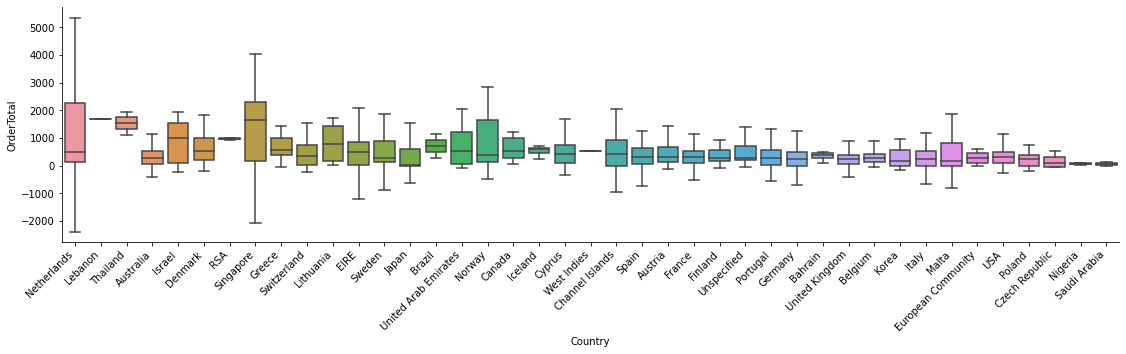

In [14]:
#create boxplots for order value for each country, sorted by the country average order value
sns.catplot(x='Country', y='OrderTotal', data=orders, kind='box', showfliers=False, 
            height=4, aspect=4, order=country_average['Country'])
plt.xticks(rotation=45, ha='right')
plt.show()

## Hypothesis Testing

In [15]:
#check where are most of the orders from
orders.Country.value_counts(ascending=False).head(10)

United Kingdom    40409
Germany            1059
EIRE                727
France              715
Netherlands         238
Spain               179
Belgium             174
Portugal            119
Sweden              118
Australia           115
Name: Country, dtype: int64

In [16]:
# check average order values for UK and Germany
country_average[country_average['Country'].str.contains('United Kingdom|Germany')]

,Country,AverageOrder
14,Germany,353.198452
38,United Kingdom,333.392068


We can see that UK and Germany are the top 2 countries where most of the orders are coming from, and we are interested in the difference in the average order values between these two countries. From the dataset, the overage order value for Germany is $20 higher than that of UK. We will use two methods: bootstrapping and t-test to test our hypothesis:

**H0: UK and Germany have the same average order value  
H1: UK and Germany have different average order values**

### Bootstrap Method

In [17]:
# calculate the difference in average order values between UK and Germany
UKMean = country_average.loc[country_average['Country']=='United Kingdom', 'AverageOrder'].values[0]
GermanyMean = country_average.loc[country_average['Country']=='Germany', 'AverageOrder'].values[0]
MeanDiff = round(GermanyMean-UKMean)
MeanDiff

20.0

In [18]:
# calculate the average order value for UK and Germany together
Mean = round(orders[orders['Country'].str.contains('United Kingdom|Germany')].OrderTotal.mean())
Mean

334

In [19]:
# shift the UK and Germany orders so they have the same average order value
uk_shifted = orders[orders['Country'] == 'United Kingdom'].OrderTotal - UKMean + Mean
germany_shifted = orders[orders['Country'] == 'Germany'].OrderTotal - GermanyMean + Mean

In [20]:
# create a Bootstrap function to draw bootstrap replicates
def Bootstrap(data, func, size=1):

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)

    return bs_replicates

In [21]:
# create bootstrap replicates for UK average order value
uk_bs = Bootstrap(uk_shifted, np.mean, size=10000)
uk_bs

array([329.4128633 , 328.68916907, 320.15775458, ..., 316.68927761,
       336.73565973, 329.92092484])

In [22]:
# create bootstrap replicates for Germany average order value
germany_bs = Bootstrap(germany_shifted, np.mean, size=10000)
germany_bs

array([305.3791492 , 322.83976393, 338.18147309, ..., 320.62022568,
       357.98115203, 364.32856468])

In [23]:
# calculate the difference between UK and Germany average order values
bs_replicates = germany_bs - uk_bs
bs_replicates

array([-24.0337141 ,  -5.84940514,  18.0237185 , ...,   3.93094807,
        21.2454923 ,  34.40763984])

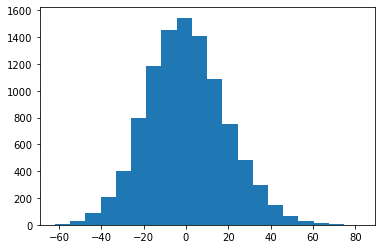

In [24]:
# check the distribution of the bootstrap replicates
plt.hist(bs_replicates,bins=20)
plt.show()

In [25]:
# calculate p-value
p = np.sum(abs(bs_replicates) >= MeanDiff) / len(bs_replicates)
print('p-value =', p)

p-value = 0.2831


**The p value from the bootstrap test is not statistically significant to reject the null hypothesis that UK and Germany have the same average order values.**

### t-test Method

In [26]:
# create series for UK and Germany order values
uk = orders[orders['Country'] == 'United Kingdom'].OrderTotal
germany = orders[orders['Country'] == 'Germany'].OrderTotal

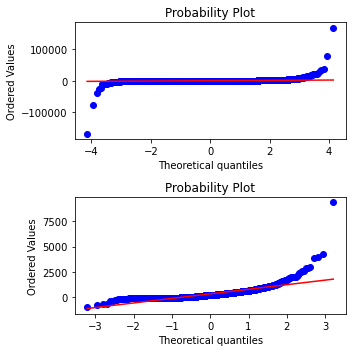

In [27]:
from scipy.stats import probplot

# create q-q plots for UK and Germany orders to check normality
plt.figure(figsize=(5,5))

plt.subplot(2,1,1)
probplot(uk,plot=plt)

plt.subplot(2,1,2)
probplot(germany,plot=plt)

plt.tight_layout()
plt.show()

**From the Q-Q plots we can see that order values for UK and Germany are not normally distributed, but since the sample size is large enough, we can still use the t-test here.**

In [28]:
from scipy import stats

# t-test for two means, specify unequal variances
t, p = stats.ttest_ind(uk, germany, equal_var = False)

print('p-value =', p)

p-value = 0.2926978598863571


**The p value from the t-test is not statistically significant to reject the null hypothesis that UK and Germany have the same average order values.**